In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions


from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


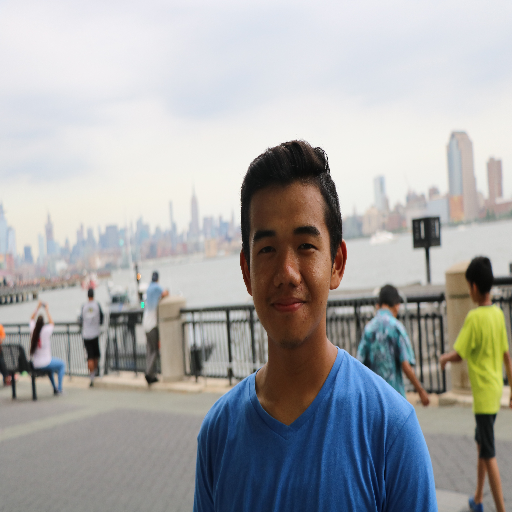

In [70]:
# Content image
height = 512
width = 512

content_image_path = 'prabhat.JPG'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

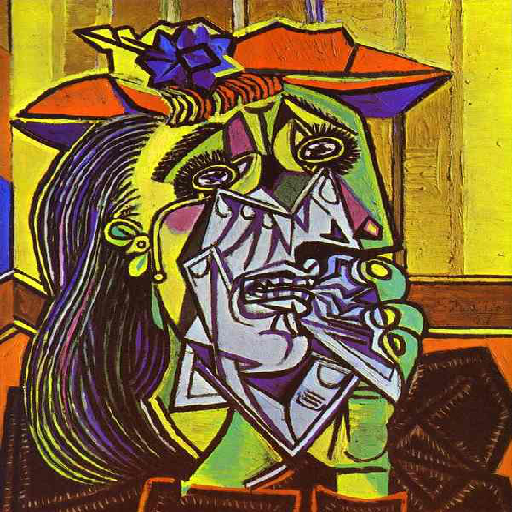

In [74]:
# import style image
style_image_path = 'the-weeping-woman.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

In [75]:
# Add another dimensions to concatenate representation of two images into a common data structure
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [76]:
# convert input images to look alike images that were trained in VGGnet: https://arxiv.org/abs/1409.1556
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [77]:
# define the result image
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [78]:
# Concatenate all three images into same tensor.
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [79]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [80]:
layers = dict([(layer.name, layer.output) for layer in model.layers])

In [101]:
# Define weights for each loss scaler weights
content_weight = 0.025
style_weight = 10.0
total_variation_weight = 1.0

In [102]:
# define final image loss
loss = backend.variable(0.)


In [103]:
# define content loss
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [104]:
# define gram matrix for  style loss
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [105]:
# deifine style loss
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [106]:
# define variational loss
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)


In [107]:
# define gradients for the loss function of final image
grads = backend.gradients(loss, combination_image)

In [108]:
# define optimizer
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [109]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 296607940000.0
Iteration 0 completed in 10s
Start of iteration 1
Current loss value: 146881740000.0
Iteration 1 completed in 8s
Start of iteration 2
Current loss value: 114605780000.0
Iteration 2 completed in 8s
Start of iteration 3
Current loss value: 98245026000.0
Iteration 3 completed in 9s
Start of iteration 4
Current loss value: 89057640000.0
Iteration 4 completed in 8s
Start of iteration 5
Current loss value: 83066500000.0
Iteration 5 completed in 8s
Start of iteration 6
Current loss value: 79621380000.0
Iteration 6 completed in 8s
Start of iteration 7
Current loss value: 76986450000.0
Iteration 7 completed in 8s
Start of iteration 8
Current loss value: 75353990000.0
Iteration 8 completed in 8s
Start of iteration 9
Current loss value: 74098860000.0
Iteration 9 completed in 8s


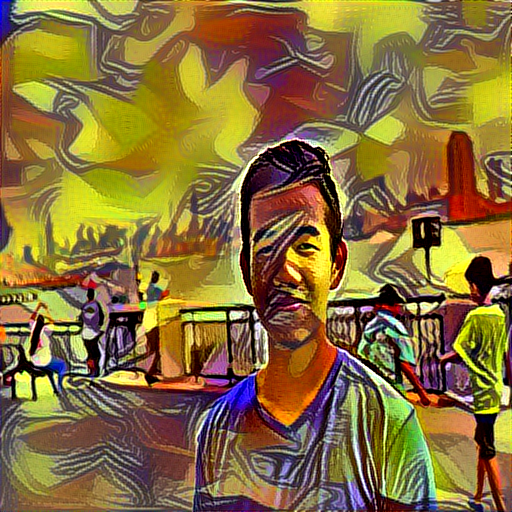

In [110]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)